# Dynamic Mode Decomposition (DMD)

Importazione delle librerie necessarie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

Selezione del dataset da utilizzare.

In [2]:
## Parametri per dataset real_eig_timeseries.mat e complex_eig_timeseries.mat
#x = np.linspace(-10, 10, 10)
#t = np.linspace(0, 20, 1600)

## Parametri per dataset XU_DMDc.mat
#x = np.linspace(-10, 10, 40)
#t = np.linspace(0, 20, 7160)

## Scelta del dataset, se a valori complessi o reali
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('XU_DMDc.mat')

## Trasformo il formato .mat in un Numpy Array
## Cambiare l'argomento di D_mat['xt'] in D_mat['X'] se si usa il dataset XU_DMDc.mat
#D_mat_list = [[element for element in upperElement] for upperElement in D_mat['xt']]
#U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]

#D = np.array(D_mat_list)
#U = np.array(U_mat_list)

## extract input-output matrices
#X = D[:,:-1]
#Y = D[:,1:]
#U = U_.shape[0]

In [3]:
## dataset_di_prova

# define time and space domains
x = np.linspace(-10, 10, 80)
t = np.linspace(0, 20, 1600)
Xm,Tm = np.meshgrid(x, t)

# create data
D = exp(-power(Xm/2, 2)) * exp(0.8j * Tm)
D += sin(0.9 * Xm) * exp(1j * Tm)
D += cos(1.1 * Xm) * exp(2j * Tm)
D += 0.6 * sin(1.2 * Xm) * exp(3j * Tm)
D += 0.6 * cos(1.3 * Xm) * exp(4j * Tm)
D += 0.2 * sin(2.0 * Xm) * exp(6j * Tm)
D += 0.2 * cos(2.1 * Xm) * exp(8j * Tm)
D += 0.1 * sin(5.7 * Xm) * exp(10j * Tm)
D += 0.1 * cos(5.9 * Xm) * exp(12j * Tm)
D += 0.1 * np.random.randn(*Xm.shape)
D += 0.03 * np.random.randn(*Xm.shape)
D += 5 * exp(-power((Xm+5)/5, 2)) * exp(-power((Tm-5)/5, 2))
D[:800,40:] += 2
D[200:600,50:70] -= 3
D[800:,:40] -= 2
D[1000:1400,10:30] += 3
D[1000:1080,50:70] += 2
D[1160:1240,50:70] += 2
D[1320:1400,50:70] += 2
D = D.T

# extract input-output matrices
X = D[:,:-1]
Y = D[:,1:]

Creazione della funzione per plottare i dati.

In [4]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time (minute)')
    plt.show()

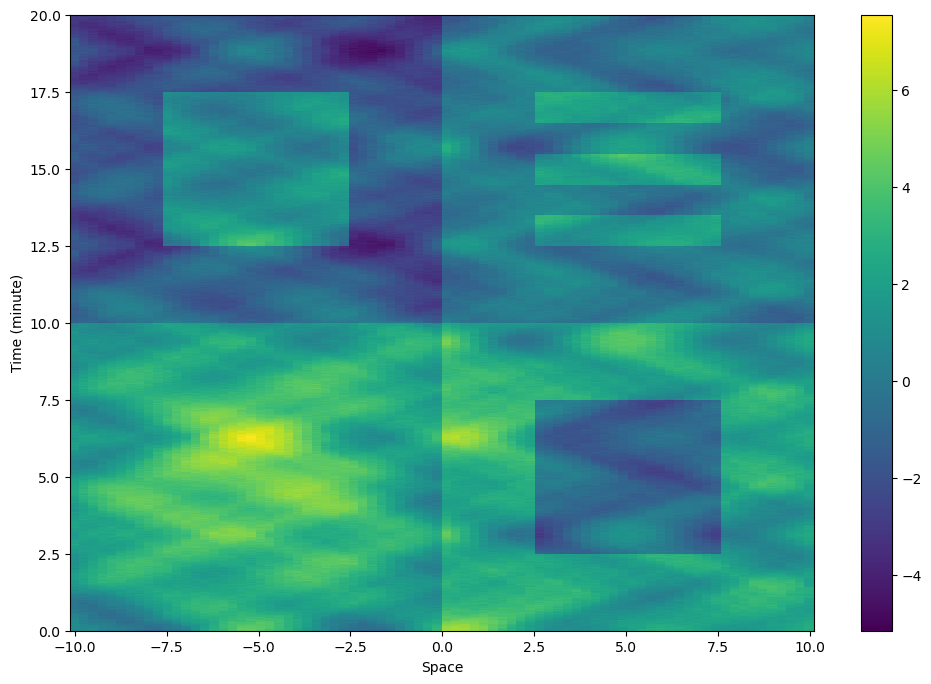

In [5]:
make_plot(D.T, x=x, y=t)

Creazione della funzione DMD.

In [6]:
def dmd(X, Y, truncate=None):
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix                 ## U2,Sig2,Vh2 SVD senza troncamento della matrice X
            
        r = len(Sig2) if truncate is None else truncate # rank truncation ## len(Sig2) equivale al numero di elementi di Sig2
        
        U = U2[:,:r]                                                      ## U matrice troncata, da (80,15) a (80,7)
        Sig = diag(Sig2)[:r,:r]                                           ## Sig matrice troncata, da (15,) a (7,7)
        V = Vh2.conj().T[:,:r]                                            ## V matrice troncata, da (15,15) a (15,7)
                                                                          ## conj() è la congiunta
        
        Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde  ## A tilde è la proiezione di A su U,
                                                                          ## dot() è il prodotto scalare tra due array
            
        mu,W = eig(Atil)                                                  ## eig() calcola gli autovalori (mu) e gli autovettori
                                                                          ## destri di una matrice quadrata
            
        Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes          ## phi equivale ai modi dinamuci del DMD
                                                                          
    return mu, Phi                                                        ## dmd restituisce mu(autovalori) e phi(modi dinamici)

# "mu" rappresenta gli autovalori del sistema dinamico rappresentato dalla matrice di dati.
# Gli autovalori sono valori numerici che descrivono la stabilità e la dinamica del sistema.

# "phi" rappresenta i modi dinamici o le funzioni proprie del sistema.
# Questi modi dinamici sono funzioni che descrivono il comportamento del sistema in base alla sua dinamica intrinseca.


Creazione della funzione per il calcolo dell'errore quadratico medio.

In [7]:
def mean_squared_error(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

Ricostruzione del DMD e calcolo dell'errore quadratico medio.

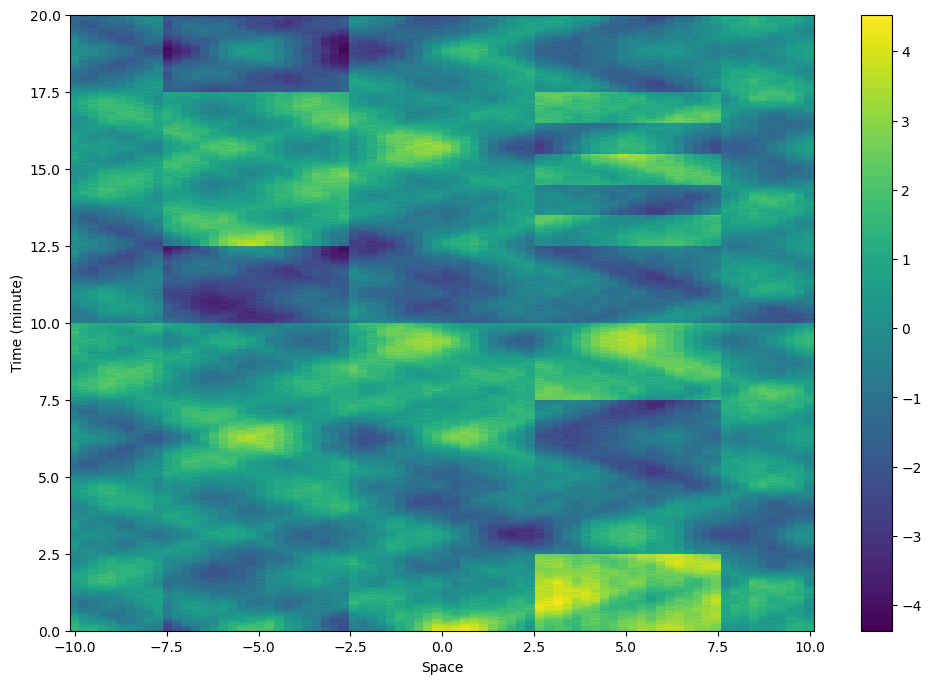

Percentuale di errore:
3.1827406781 %


In [8]:
max_cycles = 2
nyq = 8 * max_cycles                                      ## nyq = 8 * 2

# time bin size
bin_size = D.shape[1]                                     ## bin_size equivale al numero di colonne (1600)

# extract subsamples 
step = floor(bin_size / nyq) # max step size to capture cycles   ## floor è una funzione che approssima per difetto
                                                                 ## esempio floor(2.9) equivale a 2.
                                                                 ## in questo caso bin_size / nyq == 100 , quindi step=100
            
_D = D[:,::step]                                           ## D[:,:] è uno slice assignment, in particolare D[:,::step]
                                                           ## considera i valori presi ogni step di tutte le righe e crea
                                                           ## una nuova matrice con solo i valori considerati.
        
X = _D[:,:-1]                                              ## in X considera tutti i valori (di _D) escludendo l'ultima 
                                                           ## colonna.
    
Y = _D[:,1:]                                               ## in Y considera tutti i valori (di _D) escludendo la prima 
                                                           ## colonna.


r = min(X.shape)                                           ## r -> X.shape = (80, 15) quindi r=min(X.shape) è 15.
        
# compute dmd
mu,Phi = dmd(X, Y, r)                                      ## applica il dmd alle matrici campionate
    
# frequency cutoff (oscillations per timestep)
rho = max_cycles / bin_size                                ## frequenza di taglio rho definita come n° max di modi dinamici
                                                           ## classificati come "slow" diviso il numero di colonne della
                                                           ## matrice D.  2/1600=0.00125

# consolidate slow eigenvalues (as boolean mask)
slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho       ## ritorna il valore assoluto [abs()] del logaritmo di mu diviso
                                                           ## 2*pi greco*step, che deve essere minore o uguale a rho.
                                                           ## in questo caso [false false false false true true false]
        
n = sum(slow) # number of slow modes                       ## il numero dei modi "slow" è dato dalla somma di slow.
                                                           ## in questo caso 2.

# extract slow modes (perhaps empty)                       ## si estrae i modi "slow"
mu = mu[slow]                                              ## in mu salva solo gli autovalori "slow"                                                       ## da 7 autovalori a 2 autovalori.
        
Phi = Phi[:,slow]                                          ## in phi salva solo i modi dinamici "slow"
                                                           ## phi.shape era (80,7) adesso è (80,2).

if n > 0:                                                  ## se il n° di modi "slow" è maggiore di zero

    # vars for the objective function for D (before subsampling)
    Vand = np.vander(power(mu, 1/step), bin_size, True)   ## vander() restituisce una matrice di Vandermonde, come paramentri
                                                          ## vanno passati: un array 1-D (in questo caso mu elevato a potenza
                                                          ## 1/1600), il numero di colonne dell'uscita e un valore booleano
                                                          ## che indica l'incremento (se True allora le colonne saranno
                                                          ## x^0, x^1, x^2... se False saranno x^(N-1), x^(N-2),...)
                        
    P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))  ## multiply() serve per moltiplicare due array.
                                                                             ## in questo caso tra il [prodotto scalare della
                                                                             ## la congiunta di phi trasposta e phi] e 
                                                                             ## [la congiunta del prodotto scalare di Vand
                                                                             ## e la congiunta di Vand trasposta]
    q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))    ##

    # find optimal b solution
    b_opt = solve(P, q).squeeze()                         ## b = P^-1 * q
                                                          ## solve() trova le radici di P risolvendo per q

    # time evolution
    Psi = (Vand.T * b_opt).T                              ## Psi matrice (2,1600)

else:

    # zero time evolution
    b_opt = np.array([], dtype='complex')
    Psi = np.zeros([0, bin_size], dtype='complex')

# dmd reconstruction
D_dmd = dot(Phi, Psi)                                     ## D_dmd equivale al prodotto scalare tra i modi dinamici slow
                                                          ## e la matrice che rappresenta l'evoluzione nel tempo

# remove influence of slow modes
D_ = D - D_dmd                                             ## Rimuove dai dati rimanenti le componenti slow        
make_plot(D_.T, x=x, y=t)
print("Percentuale di errore:")
print(round(mean_squared_error(D_.T,D.T),10),"%")

Trasformo la matrice del dataset e la matrice della ricostruzione in array ad una dimensione.

In [9]:
D0 = D[0,:]
D_0 = D_[0,:]

Plotto l'andamento temporale sia del dataset che della ricostruzione e ne calcolo la differenza tra i due.

C:\Users\User\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


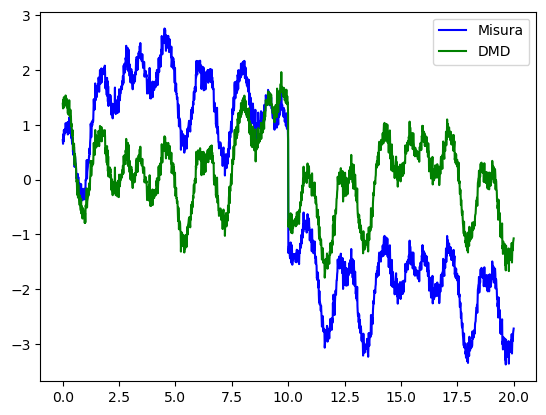

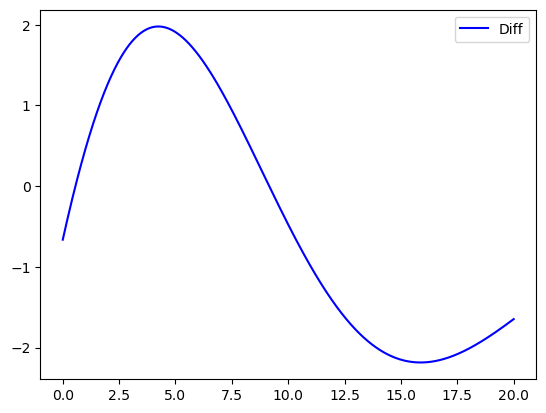

In [10]:
plt.figure()
plt.plot(t, D0, 'b', label='Misura')
plt.plot(t, D_0.real, 'g', label='DMD')
plt.legend()
plt.show()

plt.figure()
error=np.array(D0) - np.array(D_0)
plt.plot(t, error.real, 'b', label='Diff')
plt.legend()
plt.show()